### Set-up and imports

In [123]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'XXXX'

In [408]:
%matplotlib inline

from google.cloud import bigquery
from bq_helper import BigQueryHelper

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, plot_confusion_matrix, precision_recall_curve

### Import Bitcoin blockchain data

In [133]:
### https://github.com/SohierDane/BigQuery_Helper
bq_assistant = BigQueryHelper("bigquery-public-data", "bitcoin_blockchain")

In [134]:
non_miner_addresses = 25000
miner_addresses = 5000

In [174]:
sql = '''
WITH
outputs AS (
  SELECT
    ARRAY_TO_STRING(outputs.addresses,',') AS output_address,
    MIN(t.block_timestamp_month) AS output_month_min,
    MAX(t.block_timestamp_month) AS output_month_max,
    COUNT(DISTINCT t.block_timestamp_month) AS output_active_months, -- number of active months
    COUNT(t.outputs) AS output_count, -- amount of outputs from the address
    SUM(outputs.value) AS output_value_sum, -- sum of the value of all outputs from the address
    AVG(outputs.value) AS output_value_avg, -- mean value of all outputs from the address
    COUNT(DISTINCT(`hash`)) AS output_tx_count,  -- amount of output transactions from the address
    -- AVG(t.size) AS output_size_avg, -- average size of all outputs from the address
    -- SUM(t.fee) AS output_tx_fee_sum,
    -- AVG(t.fee) AS output_tx_fee_avg
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS t, UNNEST(outputs) AS outputs
  GROUP BY output_address
)
,inputs AS (
  SELECT
    ARRAY_TO_STRING(inputs.addresses,',') AS input_address,
    MIN(t.block_timestamp_month) AS input_month_min,
    MAX(t.block_timestamp_month) AS input_month_max,
    COUNT(DISTINCT t.block_timestamp_month) AS input_active_months, -- number of active months
    COUNT(t.inputs) AS input_count, -- amount of inputs to the address
    SUM(inputs.value) AS input_value_sum, -- sum of the value of all inputs to the address
    AVG(inputs.value) AS input_value_avg, -- mean value of all inputs to the address
    COUNT(DISTINCT(`hash`)) AS input_tx_count, -- amount of input transactions to the address
    -- AVG(t.size) AS input_size_avg -- average size of all inputs from the address
  FROM `bigquery-public-data.crypto_bitcoin.transactions` AS t, UNNEST(inputs) AS inputs
  GROUP BY input_address
)

(SELECT
  TRUE as is_miner,
  output_address as address,
  output_month_min,
  output_month_max,
  output_active_months,
  output_count,
  output_value_sum,
  output_value_avg,
  output_tx_count,
  input_month_min,
  input_month_max,
  input_active_months,
  input_count,
  input_value_sum,
  input_value_avg,
  input_tx_count
FROM
  outputs, inputs
WHERE
  outputs.output_address = inputs.input_address
  AND outputs.output_address IN (
    SELECT
      ARRAY_TO_STRING(outputs.addresses,',') as miner
    FROM
      `bigquery-public-data.crypto_bitcoin.transactions` AS t, UNNEST(outputs) AS outputs,
      `bigquery-public-data.crypto_bitcoin.blocks` AS b
    WHERE
      t.block_hash = b.hash
      AND t.is_coinbase IS TRUE
      AND (
        -- From https://gist.github.com/denpamusic/e90929485be3282ce0aebd4f2fd1f709
        b.coinbase_param LIKE '%48616f425443%' -- HaoBTC
        OR b.coinbase_param LIKE '%42697466757279%' -- Bitfury
        OR b.coinbase_param LIKE '%6d696e65642062792067626d696e657273%' -- mined by gbminers
        OR b.coinbase_param LIKE '%566961425443%' -- ViaBTC
        OR b.coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' -- Mined by AntPool
        OR b.coinbase_param LIKE '%4d696e65642062792031686173682e636f6d%' -- Mined by 1hash.com
        OR b.coinbase_param LIKE '%43414e4f45%' -- 七彩神仙鱼 (i.e. F2Pool)
        OR b.coinbase_param LIKE '%426974436c7562204e6574776f726b%' -- BitClub Network
        OR b.coinbase_param LIKE '%4254432e434f4d%' -- BTC.com
        OR b.coinbase_param LIKE '%4254432e544f50%' -- BTC.TOP 
        OR b.coinbase_param LIKE '%425720506f6f6c%' -- BW Pool
        OR b.coinbase_param LIKE '%42544343%' -- BTCC
        OR b.coinbase_param LIKE '%706f6f6c2e626974636f696e2e636f6d%' -- pool.bitcoin.com
        OR b.coinbase_param LIKE '%47425342335031%' -- GBSB3P1
        OR b.coinbase_param LIKE '%2f4b616e6f%' -- /Kano
        OR b.coinbase_param LIKE '%786274632e6578782e636f6d2662772e636f6d%' -- xbtc.exx.com&bw.com
        OR b.coinbase_param LIKE '%424154504f4f4c%' -- BATPOOL
        OR b.coinbase_param LIKE '%436f6e6e656374425443202d20486f6d6520666f72204d696e657273%' -- ConnectBTC - Home for Miners
        OR b.coinbase_param LIKE '%736f6c6f2e636b706f6f6c2e6f7267%' -- solo.ckpool.org
        OR b.coinbase_param LIKE '%736c757368%' -- slush
        OR b.coinbase_param LIKE '%70686173682e696f%' -- phash.io
        OR b.coinbase_param LIKE '%4269744d696e746572%' -- BitMinter
        OR b.coinbase_param LIKE '%43414e4f45%' -- CANOE
        -- From https://en.bitcoin.it/wiki/Category:Pool_Operators
        OR b.coinbase_param LIKE '%2f736c7573682f%' -- /slush/
        OR b.coinbase_param LIKE '%4b616e6f%' -- Kano
        OR b.coinbase_param LIKE '%2f7374726174756d2f%' -- /stratum/ (i.e. Btcmp)
        OR b.coinbase_param LIKE '%456c6967697573%' -- Eligius
        OR b.coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' -- /bravo-mining/
        OR b.coinbase_param LIKE '%2f6d6d706f6f6c%' -- /mmpool
        OR b.coinbase_param LIKE '%%' -- 
        OR b.coinbase_param LIKE '%%' -- 
      )
      GROUP BY miner
      HAVING COUNT(1) >= 20
  )
LIMIT {}
)
UNION ALL
(SELECT
  FALSE as is_miner,
  output_address as address,
  output_month_min,
  output_month_max,
  output_active_months,
  output_count,
  output_value_sum,
  output_value_avg,
  output_tx_count,
  input_month_min,
  input_month_max,
  input_active_months,
  input_count,
  input_value_sum,
  input_value_avg,
  input_tx_count
FROM
  outputs, inputs
WHERE
  outputs.output_address = inputs.input_address
  AND outputs.output_address NOT IN (
    SELECT
      ARRAY_TO_STRING(outputs.addresses,',') as miner
    FROM
      `bigquery-public-data.crypto_bitcoin.transactions` AS t, UNNEST(outputs) AS outputs,
      `bigquery-public-data.crypto_bitcoin.blocks` AS b
    WHERE
      t.block_hash = b.hash
      AND t.is_coinbase IS TRUE
      AND (
        -- From https://gist.github.com/denpamusic/e90929485be3282ce0aebd4f2fd1f709
        b.coinbase_param LIKE '%48616f425443%' -- HaoBTC
        OR b.coinbase_param LIKE '%42697466757279%' -- Bitfury
        OR b.coinbase_param LIKE '%6d696e65642062792067626d696e657273%' -- mined by gbminers
        OR b.coinbase_param LIKE '%566961425443%' -- ViaBTC
        OR b.coinbase_param LIKE '%4d696e656420627920416e74506f6f6c%' -- Mined by AntPool
        OR b.coinbase_param LIKE '%4d696e65642062792031686173682e636f6d%' -- Mined by 1hash.com
        OR b.coinbase_param LIKE '%43414e4f45%' -- 七彩神仙鱼 (i.e. F2Pool)
        OR b.coinbase_param LIKE '%426974436c7562204e6574776f726b%' -- BitClub Network
        OR b.coinbase_param LIKE '%4254432e434f4d%' -- BTC.com
        OR b.coinbase_param LIKE '%4254432e544f50%' -- BTC.TOP 
        OR b.coinbase_param LIKE '%425720506f6f6c%' -- BW Pool
        OR b.coinbase_param LIKE '%42544343%' -- BTCC
        OR b.coinbase_param LIKE '%706f6f6c2e626974636f696e2e636f6d%' -- pool.bitcoin.com
        OR b.coinbase_param LIKE '%47425342335031%' -- GBSB3P1
        OR b.coinbase_param LIKE '%2f4b616e6f%' -- /Kano
        OR b.coinbase_param LIKE '%786274632e6578782e636f6d2662772e636f6d%' -- xbtc.exx.com&bw.com
        OR b.coinbase_param LIKE '%424154504f4f4c%' -- BATPOOL
        OR b.coinbase_param LIKE '%436f6e6e656374425443202d20486f6d6520666f72204d696e657273%' -- ConnectBTC - Home for Miners
        OR b.coinbase_param LIKE '%736f6c6f2e636b706f6f6c2e6f7267%' -- solo.ckpool.org
        OR b.coinbase_param LIKE '%736c757368%' -- slush
        OR b.coinbase_param LIKE '%70686173682e696f%' -- phash.io
        OR b.coinbase_param LIKE '%4269744d696e746572%' -- BitMinter
        OR b.coinbase_param LIKE '%43414e4f45%' -- CANOE
        -- From https://en.bitcoin.it/wiki/Category:Pool_Operators
        OR b.coinbase_param LIKE '%2f736c7573682f%' -- /slush/
        OR b.coinbase_param LIKE '%4b616e6f%' -- Kano
        OR b.coinbase_param LIKE '%2f7374726174756d2f%' -- /stratum/ (i.e. Btcmp)
        OR b.coinbase_param LIKE '%456c6967697573%' -- Eligius
        OR b.coinbase_param LIKE '%2f627261766f2d6d696e696e672f%' -- /bravo-mining/
        OR b.coinbase_param LIKE '%2f6d6d706f6f6c%' -- /mmpool
        OR b.coinbase_param LIKE '%%' -- 
        OR b.coinbase_param LIKE '%%' -- 
      )
      GROUP BY miner
      HAVING COUNT(1) >= 20
  )
LIMIT {}
)
'''.format(miner_addreses, non_miner_addresses)

In [175]:
df = bq_assistant.query_to_pandas_safe(sql, max_gb_scanned=220)

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
is_miner                30000 non-null bool
address                 30000 non-null object
output_month_min        30000 non-null object
output_month_max        30000 non-null object
output_active_months    30000 non-null int64
output_count            30000 non-null int64
output_value_sum        30000 non-null object
output_value_avg        30000 non-null object
output_tx_count         30000 non-null int64
input_month_min         30000 non-null object
input_month_max         30000 non-null object
input_active_months     30000 non-null int64
input_count             30000 non-null int64
input_value_sum         30000 non-null object
input_value_avg         30000 non-null object
input_tx_count          30000 non-null int64
dtypes: bool(1), int64(6), object(9)
memory usage: 3.5+ MB


In [177]:
df.head(5)

,is_miner,address,output_month_min,output_month_max,output_active_months,output_count,output_value_sum,output_value_avg,output_tx_count,input_month_min,input_month_max,input_active_months,input_count,input_value_sum,input_value_avg,input_tx_count
0,False,1MZ722X9i2mSxLUeqmUVWoEFuqvZAvyHvF,2013-06-01,2013-06-01,1,1,2239282052,2239282052,1,2013-07-01,2013-07-01,1,1,2239282052,2239282052,1
1,False,14vEp1Pwoxw9iggHGdCTwz3NPegpaivnxP,2011-08-01,2011-08-01,1,1,420284537,420284537,1,2011-08-01,2011-08-01,1,1,420284537,420284537,1
2,False,1LpEpNs7PtABxPjbMab5mj3HFfCjpxtxah,2013-06-01,2013-06-01,1,1,3326760,3326760,1,2013-06-01,2013-06-01,1,1,3326760,3326760,1
3,False,1MdWK5eLam5hvDEri8hxfofAXnqmVDLnEc,2020-07-01,2020-07-01,1,1,119624,119624,1,2020-09-01,2020-09-01,1,1,119624,119624,1
4,False,19ZMLUCDVHeWChbuFpSN2EX23gzHwewU59,2012-03-01,2012-09-01,7,29,11539000000,397896551.724137931,29,2012-03-01,2012-09-01,7,28,11525000000,411607142.857142857,24


In [268]:
df1 = df.copy() # backup of df
df1.head()

,is_miner,address,output_month_min,output_month_max,output_active_months,output_count,output_value_sum,output_value_avg,output_tx_count,input_month_min,input_month_max,input_active_months,input_count,input_value_sum,input_value_avg,input_tx_count
0,False,1MZ722X9i2mSxLUeqmUVWoEFuqvZAvyHvF,2013-06-01,2013-06-01,1,1,2239282052,2239282052,1,2013-07-01,2013-07-01,1,1,2239282052,2239282052,1
1,False,14vEp1Pwoxw9iggHGdCTwz3NPegpaivnxP,2011-08-01,2011-08-01,1,1,420284537,420284537,1,2011-08-01,2011-08-01,1,1,420284537,420284537,1
2,False,1LpEpNs7PtABxPjbMab5mj3HFfCjpxtxah,2013-06-01,2013-06-01,1,1,3326760,3326760,1,2013-06-01,2013-06-01,1,1,3326760,3326760,1
3,False,1MdWK5eLam5hvDEri8hxfofAXnqmVDLnEc,2020-07-01,2020-07-01,1,1,119624,119624,1,2020-09-01,2020-09-01,1,1,119624,119624,1
4,False,19ZMLUCDVHeWChbuFpSN2EX23gzHwewU59,2012-03-01,2012-09-01,7,29,11539000000,397896551.724137931,29,2012-03-01,2012-09-01,7,28,11525000000,411607142.857142857,24


In [178]:
df['is_miner'].unique()

array([False,  True])

In [269]:
# Convert to numeric values
labels_value = ['output_value_sum', 'output_value_avg', 'input_value_sum', 'input_value_avg']
df[labels_value] = df[labels_value].apply(pd.to_numeric)

# Convert to UNIX epoch timestamp (seconds) to have an integer value
labels_timestamp = ['output_month_min', 'output_month_max', 'input_month_min', 'input_month_max']
df[labels_timestamp] = (df[labels_timestamp].apply(pd.to_datetime)
                           - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Create list with remaining features (needed later for preprocessing step)
labels_rest = features.drop(labels_value, axis=1).drop(labels_timestamp, axis=1).columns.tolist()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 16 columns):
is_miner                30000 non-null bool
address                 30000 non-null object
output_month_min        30000 non-null int64
output_month_max        30000 non-null int64
output_active_months    30000 non-null int64
output_count            30000 non-null int64
output_value_sum        30000 non-null float64
output_value_avg        30000 non-null float64
output_tx_count         30000 non-null int64
input_month_min         30000 non-null int64
input_month_max         30000 non-null int64
input_active_months     30000 non-null int64
input_count             30000 non-null int64
input_value_sum         30000 non-null float64
input_value_avg         30000 non-null float64
input_tx_count          30000 non-null int64
dtypes: bool(1), float64(4), int64(10), object(1)
memory usage: 3.5+ MB


In [270]:
df.head()

,is_miner,address,output_month_min,output_month_max,output_active_months,output_count,output_value_sum,output_value_avg,output_tx_count,input_month_min,input_month_max,input_active_months,input_count,input_value_sum,input_value_avg,input_tx_count
0,False,1MZ722X9i2mSxLUeqmUVWoEFuqvZAvyHvF,1370044800,1370044800,1,1,2.239282e+09,2.239282e+09,1,1372636800,1372636800,1,1,2.239282e+09,2.239282e+09,1
1,False,14vEp1Pwoxw9iggHGdCTwz3NPegpaivnxP,1312156800,1312156800,1,1,4.202845e+08,4.202845e+08,1,1312156800,1312156800,1,1,4.202845e+08,4.202845e+08,1
2,False,1LpEpNs7PtABxPjbMab5mj3HFfCjpxtxah,1370044800,1370044800,1,1,3.326760e+06,3.326760e+06,1,1370044800,1370044800,1,1,3.326760e+06,3.326760e+06,1
3,False,1MdWK5eLam5hvDEri8hxfofAXnqmVDLnEc,1593561600,1593561600,1,1,1.196240e+05,1.196240e+05,1,1598918400,1598918400,1,1,1.196240e+05,1.196240e+05,1
4,False,19ZMLUCDVHeWChbuFpSN2EX23gzHwewU59,1330560000,1346457600,7,29,1.153900e+10,3.978966e+08,29,1330560000,1346457600,7,28,1.152500e+10,4.116071e+08,24


### Split train and test data

In [272]:
features = df.drop(['address', 'is_miner'], axis=1)
target = df['is_miner']

In [299]:
features.head()

,output_month_min,output_month_max,output_active_months,output_count,output_value_sum,output_value_avg,output_tx_count,input_month_min,input_month_max,input_active_months,input_count,input_value_sum,input_value_avg,input_tx_count
0,1370044800,1370044800,1,1,2.239282e+09,2.239282e+09,1,1372636800,1372636800,1,1,2.239282e+09,2.239282e+09,1
1,1312156800,1312156800,1,1,4.202845e+08,4.202845e+08,1,1312156800,1312156800,1,1,4.202845e+08,4.202845e+08,1
2,1370044800,1370044800,1,1,3.326760e+06,3.326760e+06,1,1370044800,1370044800,1,1,3.326760e+06,3.326760e+06,1
3,1593561600,1593561600,1,1,1.196240e+05,1.196240e+05,1,1598918400,1598918400,1,1,1.196240e+05,1.196240e+05,1
4,1330560000,1346457600,7,29,1.153900e+10,3.978966e+08,29,1330560000,1346457600,7,28,1.152500e+10,4.116071e+08,24


In [300]:
target.head()

0    False
1    False
2    False
3    False
4    False
Name: is_miner, dtype: bool

In [277]:
features.shape, target.shape

((30000, 14), (30000,))

In [281]:
X_train, X_test, y_train, y_test = train_test_split(features, target)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22500, 14), (7500, 14), (22500,), (7500,))

### Check correlation of features

<IPython.core.display.Javascript object>


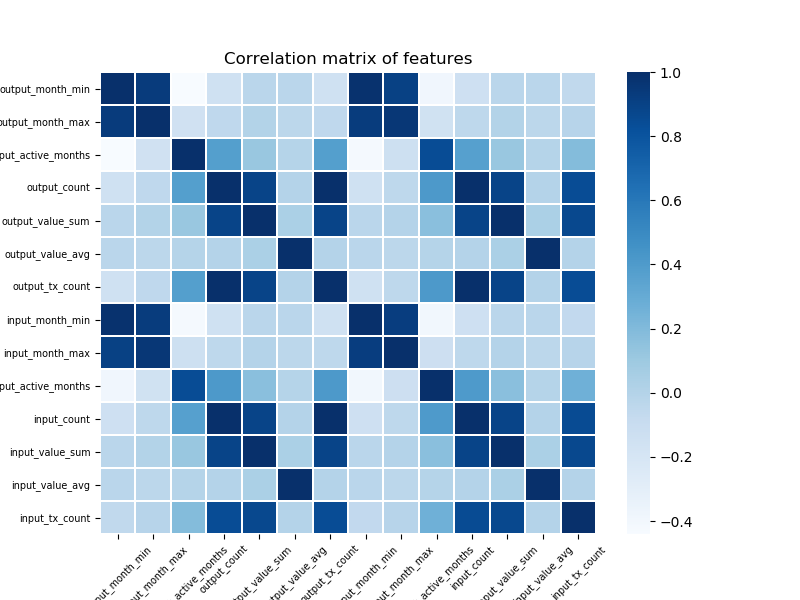

In [347]:
corr = features.corr(method='pearson')
plt.figure(figsize=(8,6))
ax = sns.heatmap(corr, cmap='Blues', linewidth=0.8)
ax.set_title('Correlation matrix of features', fontsize='large')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize='x-small');
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='x-small');

### Train model

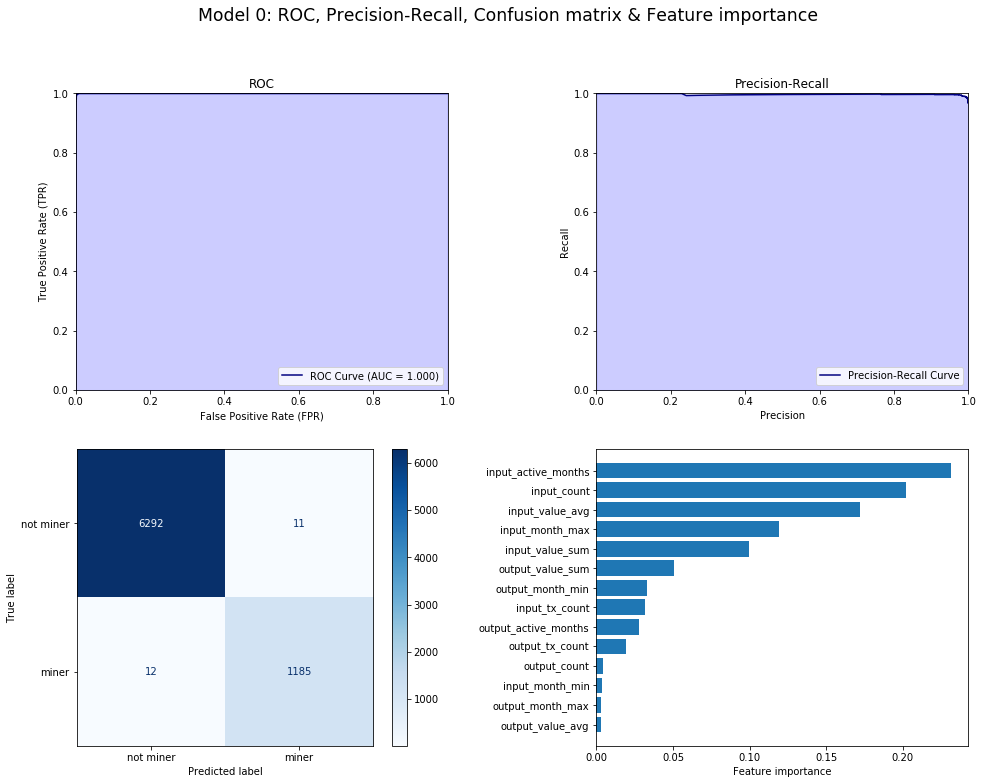

Best params: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__n_estimators': 50}
Best training accuracy: 0.998
AUC score: 1.000


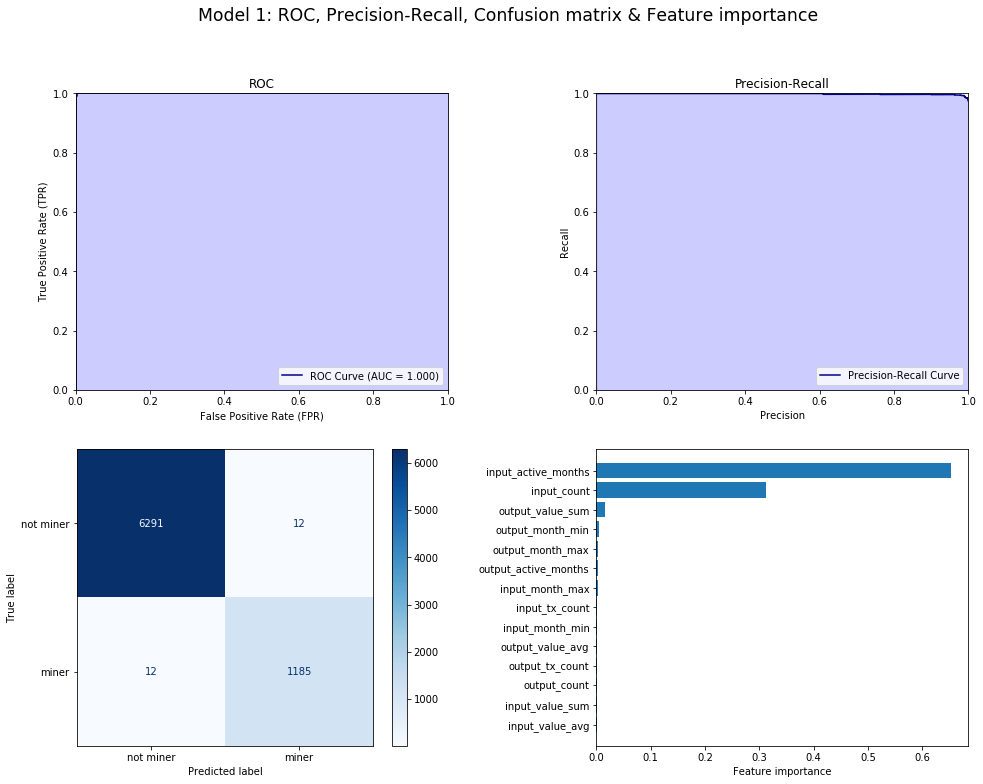

Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 100}
Best training accuracy: 0.998
AUC score: 1.000


In [479]:
# Set up feature preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), labels_value),
        ('minmax_timestamp', MinMaxScaler(), labels_timestamp),
        ('minmax_rest', MinMaxScaler(), labels_rest)
    ]
)

# Set up pipeline for each model
pipe_rf = Pipeline(steps=[('scl', preprocessor),
                        ('clf', RandomForestClassifier())])
pipe_gbdt = Pipeline(steps=[('scl', preprocessor),
                        ('clf', GradientBoostingClassifier())])

# Define parameters for each grid search
param_grid_rf = {
    'clf__n_estimators': [10, 50],
    'clf__max_depth': [5, 10],
    'clf__max_features': ['sqrt', 'log2', None]
}
param_grid_gbdt = {
    'clf__learning_rate': [0.1, 1],
    'clf__n_estimators': [10, 100],
    'clf__max_depth': [2, 5]
}

# Set up grid search for each pipeline
gs_lr = GridSearchCV(pipe_lr, param_grid_lr, n_jobs= 1)
gs_rf = GridSearchCV(pipe_rf, param_grid_rf, n_jobs= 1)
gs_gbdt = GridSearchCV(pipe_gbdt, param_grid_gbdt, n_jobs= 1)

#grids = [gs_lr, gs_rf]
grids = [gs_rf, gs_gbdt]

# Functions for plotting of results
def plot_roc(ax, fpr, tpr, auc_score):
    ax.plot(fpr, tpr, label='ROC Curve (AUC = {:0.3f})'.format(auc_score), color='navy')
    ax.set_title('ROC', fontsize='large')
    ax.set_xlabel('False Positive Rate (FPR)', fontsize='medium')
    ax.set_ylabel('True Positive Rate (TPR)', fontsize='medium')
    ax.tick_params(axis='both', labelsize='medium')
    ax.legend(loc='lower right', fontsize='medium')
    ax.fill_between(fpr, tpr, alpha=0.2, color='b')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

def plot_prec_recall(ax, precision, recall):
    ax.plot(recall, precision, label='Precision-Recall Curve', color='navy')
    ax.set_title('Precision-Recall', fontsize='large')
    ax.set_xlabel('Precision', fontsize='medium')
    ax.set_ylabel('Recall', fontsize='medium')
    ax.tick_params(axis='both', labelsize='medium')
    ax.legend(loc='lower right', fontsize='medium')
    ax.fill_between(recall, precision, alpha=0.2, color='b')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

def plot_cm(ax, gs, X_test, y_test):
    class_labels = ['not miner', 'miner']
    plot_confusion_matrix(gs, X_test, y_test,
                              display_labels = class_labels,
                              values_format = '.5g',
                              cmap='Blues',
                              ax=ax)

def plot_feature_importances(ax, gs):
    feature_importances = gs.best_estimator_.named_steps['clf'].feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    feature_importances = feature_importances[indices]
    cols = features.columns[indices]
    n_features = len(features.columns)
    x_pos = np.arange(n_features)
    x_pos = x_pos[:n_features][::-1]
    feature_importances = feature_importances[:n_features]
    #print(x_pos.shape, feature_importances.shape, indices, x_pos, feature_importances, cols)
    
    ax.barh(x_pos, feature_importances, tick_label=cols)
    ax.set_xlabel('Feature importance', fontsize='medium')

# Loop through and run models
for i, gs in enumerate(grids):
    # Run models
    gs.fit(X_train, y_train)
    y_prob = gs.predict_proba(X_test)[:,1] # predicted probabilities in interval [0,1]
    y_pred = gs.predict(X_test) # predicted actual values
    
    # Calculate scores
    auc_score = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    
    # Call plot functions
    fig, axes = plt.subplots(2, 2, figsize=(16,12))
    plt.suptitle('Model {}: ROC, Precision-Recall, Confusion matrix & Feature importance'.format(i), fontsize='xx-large')
    plt.subplots_adjust(wspace=0.4, hspace=0.2)
    
    plot_roc(axes[0, 0], fpr, tpr, auc_score) # ROC Curve
    plot_prec_recall(axes[0, 1], precision, recall) # Precision-Recall Curve
    plot_cm(axes[1, 0], gs, X_test, y_test) # Confusion Matrix
    plot_feature_importances(axes[1, 1], gs) # Feature Importances
    
    plt.show()
        
    # Print outputs
    print('Best params: %s' % gs.best_params_)
    print('Best training accuracy: %.3f' % gs.best_score_)
    print('AUC score: %.3f' % auc_score)